## PEFT - Parameter-Efficient Fine-Tuning

büyük pretrained modeller için verimli fine-tuning yöntemleri içeren yapı.

LoRA: Low-Rank Adaptation of Large Language Models
İnce ayarı daha verimli hale getirmek için LoRA'nın yaklaşımı, ağırlık güncellemelerini düşük dereceli ayrıştırma yoluyla iki küçük matrisle ( güncelleme matrisleri olarak adlandırılır) temsil etmektir. Bu yeni matrisler, genel değişiklik sayısını düşük tutarken yeni verilere uyum sağlayacak şekilde eğitilebilir. Orijinal ağırlık matrisi donmuş halde kalır ve başka ayarlama yapılmaz. Nihai sonuçları elde etmek için hem orijinal hem de uyarlanmış ağırlıklar birleştirilir.

#### PEFT'e geçmeden önce LoRA ile image classification örneği

Lora'ya dair notlar:

->Prensip olarak LoRA, eğitilebilir parametrelerin sayısını azaltmak için bir sinir ağındaki herhangi bir ağırlık matrisi alt kümesine uygulanabilir. Ancak basitlik ve parametre verimliliği açısından Transformer modellerinde LoRA genellikle yalnızca dikkat bloklarına uygulanır

In [1]:
!pip install transformers accelerate evaluate datasets peft -q

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import transformers
import accelerate
import peft

print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")
'''
"Transformers version: 4.27.4"
"Accelerate version: 0.18.0"
"PEFT version: 0.2.0"

'''

Transformers version: 4.34.0
Accelerate version: 0.23.0
PEFT version: 0.5.0


'\n"Transformers version: 4.27.4"\n"Accelerate version: 0.18.0"\n"PEFT version: 0.2.0"\n\n'

In [4]:
model_checkpoint = "google/vit-base-patch16-224-in21k"

## Preprocessing

In [5]:
from datasets import load_dataset

dataset = load_dataset("food101", split="train[:5000]")

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x784F84A5CA00>, 'label': 6}


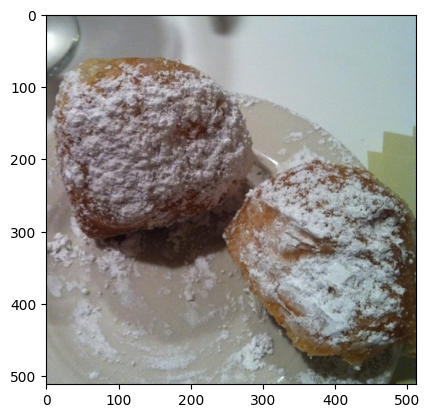

In [6]:
## sample pic
print(dataset[128])
plt.imshow(dataset[128]['image'])

In [8]:
labels = dataset.features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [9]:
##len(id2label) = 101. Bu kadar çeşit tatlı var
unique_values = list(id2label.values())
print(unique_values)
print(len(unique_values))
print(id2label[9])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [10]:
id2label[10]

'bruschetta'

In [11]:
from transformers import AutoImageProcessor
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
##Transformers kütüphanesini kullanarak belirli bir önceden eğitilmiş bir görüntü işleme modelini yükleme kısmı

In [12]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [13]:
splits = dataset.train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [14]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

## Loading and preparing the model

In [15]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

####### Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']

In [16]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

##ignore_mismatched_sizes parametresi, modelin ağırlıklarının boyutları ile ilgili bir uyumsuzluk durumunda
##(örneğin, önceden eğitilmiş bir modeli daha fazla eğitmek istediğinizde) kullanılır.

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print_trainable_parameters(model)

trainable params: 85876325 || all params: 85876325 || trainable%: 100.00


In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)


trainable params: 745162 || all params: 86543818 || trainable%: 0.86


In [19]:
## modelin modullerine bakmak istersen
#for name, module in model.named_modules():
       # print(name, module)

##### Temel model get_peft_model ile wrap edildikten sonra önceden eğitilmiş parametrelerin dondurulduğu, yalnızca LORA parametrelerinin eğitildiği bir model elde edilir. lora_model dediği budur. Ancak sadece LORA parametrelerinin eğitilmesi yeterli olmaz. Çünkü biz sınıflandırma parametrelerinin de eğitilmesini istiyoruz. Bu sebeple modules_to_save değişkeninde tutulması istenen kısımları tutuyoruz.

#### ONEMLİ Amaç parametre açısından fine tuning yapmak olduğundan  orijinal modelle karşılaştırıldığında daha az eğitilebilir parametre görmeyi beklemeliyiz ki burada da durum budur.

### Defining the training arguments

In [19]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

In [20]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [21]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

collate_fn in mantığı aşağıdaki linkte çok güzel anlatılmış. kısaca batchleri efektif kullanmak adına yapılıyor: https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

## Train and evaluate

In [23]:
from huggingface_hub import notebook_login
notebook_login()

In [24]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.605109,0.868000
2,2.172100,0.225799,0.932000
3,0.365800,0.152941,0.956000
4,0.208100,0.134747,0.958000
5,0.178000,0.132942,0.958000


In [26]:
trainer.evaluate(val_ds)


{'eval_loss': 0.13474658131599426,
 'eval_accuracy': 0.958,
 'eval_runtime': 7.3062,
 'eval_samples_per_second': 68.435,
 'eval_steps_per_second': 0.547,
 'epoch': 5.0}

In [27]:
repo_name = f"asude/{model_name}-finetuned-lora-food101"
lora_model.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/Asude/vit-base-patch16-224-in21k-finetuned-lora-food101/commit/10459e13be9199bbe2ff498556c71b9e550d3629', commit_message='Upload model', commit_description='', oid='10459e13be9199bbe2ff498556c71b9e550d3629', pr_url=None, pr_revision=None, pr_num=None)

## Run inference

In [28]:
from peft import PeftConfig, PeftModel

In [29]:
config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
# Load the LoRA model
inference_model = PeftModel.from_pretrained(model, repo_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


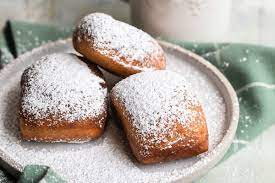

In [30]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [31]:
image_processor = AutoImageProcessor.from_pretrained(repo_name)
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [33]:
with torch.no_grad():
    outputs = inference_model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", inference_model.config.id2label[predicted_class_idx])


Predicted class: beignets
